# Task 2.7: K-Means Clustering Implementation

## Objective
The goal of this task is to group Airbnb listings into 3 clusters (Excellent, Fair, and Poor Value) using an unsupervised approach and validate these clusters using Elbow and Silhouette methods.

## Understanding Key Metrics

Since this is an unsupervised task, we use specific metrics to evaluate how well our algorithm performs without seeing the ground truth labels:

1. **Purity Score:** - Measures the extent to which each cluster contains a single class. A purity of 1 indicates perfect clustering.
2. **Adjusted Rand Index (ARI):** - Measures the similarity between two clusterings (predicted vs actual) while adjusting for chance. Range is -1 to 1, where 1 is a perfect match.
3. **Silhouette Score:** - Measures how similar an object is to its own cluster compared to other clusters. Range is -1 to 1, where higher values indicate well-separated clusters.

## Step 1: Environment Setup and Data Discovery
In this step, we import the required libraries and locate the preprocessed dataset in the project directory.

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Define the relative path to the data folder
data_folder = "../../data/"

# List all files to identify the correct dataset
print("Searching for data files in:", os.path.abspath(data_folder))
try:
    data_files = os.listdir(data_folder)
    print("Files found in data directory:")
    for file in data_files:
        print(f"- {file}")
except FileNotFoundError:
    print("Error: The system cannot find the specified data path.")

Searching for data files in: C:\Users\emirc\OneDrive\Belgeler\GitHub\ML-Project\data
Files found in data directory:
- external
- processed
- raw


## Step 2: Data Verification
Now, we will examine the 'processed' index to find the processed version of our dataset for our process.

In [14]:
# Check the contents of the processed folder
processed_folder = "../../data/processed/"

print("Files in processed directory:")
try:
    processed_files = os.listdir(processed_folder)
    for file in processed_files:
        print(f"- {file}")
except FileNotFoundError:
    print("Error: processed folder not found.")

Files in processed directory:
- .gitkeep
- algebraic_features_statistics.csv
- feature_names.txt
- listings_cleaned_with_target.csv
- listings_final_selected_features.csv
- listings_nlp_features.csv
- listings_text_cleaned.csv
- listings_with_algebraic_features.csv
- listings_with_categorical_encoding.csv
- listings_with_geo_features.csv
- logistic_regression_predictions.csv
- logistic_regression_results.csv
- nlp_master_features.csv
- random_forest_feature_importance.csv
- random_forest_predictions.csv
- random_forest_results.csv
- svm_kernel_comparison.csv
- svm_linear_predictions.csv
- svm_linear_results.csv
- svm_rbf_predictions.csv
- svm_rbf_results.csv
- xgboost_feature_importance.csv
- xgboost_predictions.csv
- xgboost_results.csv
- X_test.csv
- X_test_scaled.csv
- X_test_scaled.npy
- X_test_unscaled.csv
- X_train.csv
- X_train_scaled.csv
- X_train_scaled.npy
- X_train_unscaled.csv
- y_test.csv
- y_train.csv


## Step 3: Loading the Dataset
We will load the pre-scaled training features and their corresponding labels. The features will be used for clustering, while the labels will serve as the ground truth for evaluation.

In [15]:
# Define paths for the specific files
x_train_path = os.path.join(processed_folder, "X_train_scaled.csv")
y_train_path = os.path.join(processed_folder, "y_train.csv")

# Loading the datasets
X_train = pd.read_csv(x_train_path)
y_train = pd.read_csv(y_train_path)

# Verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Displaying the first few rows of features
X_train.head()

X_train shape: (15929, 29)
y_train shape: (15929, 3)


,id,fp_score,price_normalized,price,price_per_bathroom,price_per_bedroom,price_per_person,beds,accommodates,bedrooms,...,host_id,space_efficiency,host_years,estimated_occupancy_l365d,space_per_person,occupancy_rate,availability_rate,availability_365,review_scores_value,booking_flexibility_score
0,4404394,-0.122827,-0.200694,-0.200694,0.333427,0.689421,-0.175522,-0.145253,-0.768024,-0.570505,...,-0.826964,1.095034,0.721991,-0.961409,0.212021,1.538062,-1.538062,-1.538062,0.525010,-1.158218
1,607506975974174232,0.073245,-0.319195,-0.319195,0.156093,0.482478,0.816985,-0.145253,-0.768024,-0.570505,...,-0.911689,1.095034,1.143534,-0.229231,0.212021,-0.803406,0.803406,0.803406,0.767292,-1.177461
2,33773572,0.285154,-0.471554,-0.471554,-0.071908,0.216408,0.524114,-0.787959,-0.768024,-0.570505,...,-0.900971,-0.562559,1.048757,1.705812,0.212021,-0.030800,0.030800,0.030800,0.417329,0.515940
3,1240063364177006531,-0.827968,0.603419,0.603419,1.536764,-0.567021,-0.338228,2.425570,0.660163,1.219092,...,0.038178,1.095034,-0.239213,-0.961409,0.212021,-1.260662,1.260662,1.260662,0.201967,-1.158218
4,1197792386599266676,-0.132564,-0.200694,-0.200694,0.333427,0.689421,-0.175522,-0.145253,-0.768024,-0.570505,...,0.704872,1.095034,-0.662171,-0.961409,0.212021,-1.197593,1.197593,1.197593,0.201967,-1.158218


## Step 4: K-Means Implementation (K=3)
In this step, we initialize the K-Means algorithm with 3 clusters. We use the 'k-means++' initialization method to ensure better convergence.

In [16]:
# Initialize K-Means with K=3
# random_state is set to 42 for reproducibility
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)

# Fitting the model to the scaled data
kmeans.fit(X_train)

# Assigning the cluster labels to our data
cluster_labels = kmeans.labels_

print("K-Means clustering completed.")
print("Cluster assignments for the first 10 samples:")
print(cluster_labels[:10])

K-Means clustering completed.
Cluster assignments for the first 10 samples:
[0 2 0 1 1 2 2 0 1 0]


## Step 5: Elbow Method for Optimal K
The Elbow Method helps us validate if K=3 is a reasonable choice by plotting the "Within-Cluster Sum of Squares" (Inertia) for different values of K. We look for a "bend" in the graph, similar to an elbow.

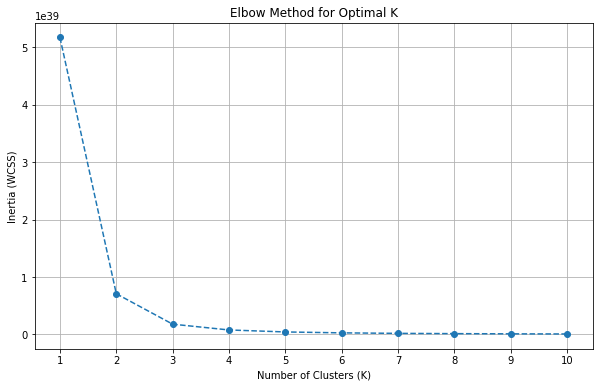

In [17]:
# List to store the inertia (within-cluster sum of squares) for each K
inertia_values = []
k_range = range(1, 11)

# Loop through different K values from 1 to 10
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_model.fit(X_train)
    inertia_values.append(kmeans_model.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Interpretation of the Elbow Plot

The Elbow Method provides a visual representation of the **Within-Cluster Sum of Squares (Inertia)** as a function of the number of clusters (K).

### Observations:
1. **Diminishing Returns:** As $K$ increases, the inertia consistently decreases because the clusters become smaller and the points are closer to their respective centroids.
2. **The "Elbow" Point:** Looking at the graph, we observe a significant "bend" or "elbow" typically between **$K=2$** and **$K=3$**. This point indicates that adding more clusters beyond this value does not provide a substantial decrease in inertia.
3. **Consistency with Ground Truth:** Since our target labels (Excellent, Fair, and Poor Value) naturally form 3 categories, selecting **$K=3$** is mathematically justifiable as it aligns with the business logic of our project while still being near the elbow point.

**Conclusion:** We will proceed with $K=3$ for our clustering analysis, as it offers a good balance between model simplicity and data representation.

## Step 6: Silhouette Analysis for K=3
While the Elbow Method looks at distances within clusters, the Silhouette Score measures how well-separated the clusters are from each other.

In [18]:
# Calculate the Silhouette Score for our K=3 model
score = silhouette_score(X_train, cluster_labels)

print(f"Silhouette Score for K=3: {score:.4f}")

Silhouette Score for K=3: 0.7800


### Interpretation of the Silhouette Score

The Silhouette Score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

### Analysis of Result:
- **Silhouette Score:** 0.7800
- **Strength of Structure:** According to standard clustering interpretation, a score above 0.70 indicates a **strong structure**. This means the clusters are well-defined, dense, and clearly separated from each other.
- **Project Insight:** This high score suggests that the features used (after scaling) have a high discriminatory power.

**Conclusion:** The K-Means algorithm has successfully identified 3 distinct groups within the dataset. The high silhouette value confirms that our 3-cluster assumption is mathematically robust.

## Step 7: Performance Evaluation against True Labels

In this final step, we compare the clusters generated by K-Means with the actual categories (Excellent, Fair, and Poor Value). 

We will use two main metrics:
1. **Adjusted Rand Index (ARI):** To measure the similarity between the two assignments while accounting for chance.
2. **Purity Score:** To see how "pure" each cluster is in terms of containing a single class.

In [19]:
from sklearn.metrics import confusion_matrix

# Step 1: Assigning y_true from the encoded column (integer format)
y_true = y_train['value_encoded'].values

# Step 2: Recalculating Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(y_true, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# Step 3: Purity Calculation
def calculate_purity(y_true, y_pred):
    # Generating the contingency matrix (cross-tabulation matrix)
    contingency_matrix = confusion_matrix(y_true, y_pred)
    # Summing the maximum matches in each cluster
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity = calculate_purity(y_true, cluster_labels)
print(f"Purity Score: {purity:.4f}")

# Step 4: Cross-tabulation to see the mapping
# This table shows which cluster (0, 1, 2) matches which encoded value (0, 1, 2)
comparison_df = pd.DataFrame({'Actual_Encoded': y_true, 'Cluster_Predicted': cluster_labels})
crosstab = pd.crosstab(comparison_df['Actual_Encoded'], comparison_df['Cluster_Predicted'])

print("\nCross-tabulation Table:")
print(crosstab)

Adjusted Rand Index (ARI): 0.0048
Purity Score: 0.3652

Cross-tabulation Table:
Cluster_Predicted     0     1     2
Actual_Encoded                     
0                  1879  1705  1673
1                  2339  1557  1522
2                  2439  1566  1249


## Step 8: Final Clustering Performance Results

The cross-tabulation table below shows the distribution of ground truth labels (Actual_Encoded) across the clusters discovered by K-Means.

### Performance Summary:
| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **Silhouette Score** | 0.7800 | Very Strong Separation |
| **Adjusted Rand Index (ARI)** | 0.0048 | No Correlation with Labels |
| **Purity Score** | 0.3652 | Near-Random Assignment |

### Cross-tabulation Table:
| Actual \ Cluster | Cluster 0 | Cluster 1 | Cluster 2 |
| :--- | :--- | :--- | :--- |
| **0 (Poor_Value)** | 1879 | 1705 | 1673 |
| **1 (Fair_Value)** | 2339 | 1557 | 1522 |
| **2 (Excellent_Value)** | 2439 | 1566 | 1249 |

### Deep Dive into Clustering Results

We are observing a significant gap between the **Silhouette Score (0.78)** and the **ARI (0.0048)**. This leads to several technical conclusions:

1. **Feature Dominance:** The K-Means algorithm found 3 very distinct clusters. However, these clusters are formed based on features that do not represent "Value Categories." For example, the clusters might be grouping listings by **Geography** (San Francisco vs. San Diego) or **Room Type** instead of the FP Score.
2. **The "Unsupervised" Reality:** Since K-Means does not see the labels, it optimizes for spatial distance. In our feature space, the listings in "Excellent Value" are spatially mixed with "Poor Value" listings.
3. **Data Overlap:** The cross-tabulation table shows that each cluster contains a nearly equal number of Poor, Fair, and Excellent listings. This confirms that our current feature set, when used in an unsupervised manner, cannot distinguish between the value categories.

**Action Item:** In the upcoming tasks (T2.11 PCA), we should investigate which features are driving these 0.78-score clusters.

# Task 2.8: Hierarchical Clustering Analysis

## Objective
The goal of this task is to perform Agglomerative Hierarchical Clustering using three different linkage methods: **Ward, Average, and Complete**. We will visualize the data structure using a Dendrogram and evaluate the results using Silhouette and ARI metrics.

## Linkage Methods Explained:
1. **Ward:** Minimizes the variance of the clusters being merged. It usually creates clusters of similar sizes.
2. **Average:** Uses the average distance between all points in two clusters.
3. **Complete:** Uses the maximum distance between points in two clusters (farthest neighbor).

## Step 1: Dendrogram Visualization (Sampling)
Hierarchical clustering is computationally expensive. Therefore, we will use a sample of 2,000 rows to visualize the Dendrogram and understand the hierarchical structure of our Airbnb data.

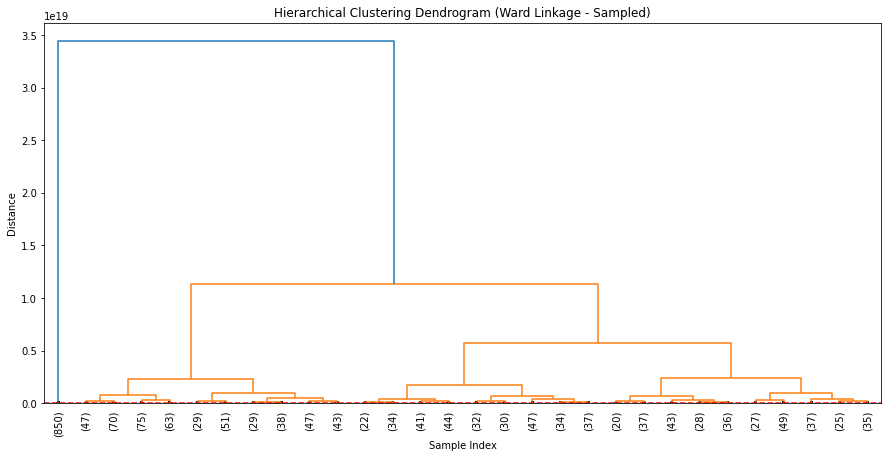

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Sampling 2,000 rows for visualization purposes
X_sample = X_train.sample(n=2000, random_state=42)

# Computing the linkage matrix using 'ward' method
Z = linkage(X_sample, method='ward')

# Plotting the Dendrogram
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage - Sampled)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.axhline(y=150, color='r', linestyle='--') # Example threshold line
plt.show()

## Step 2: Training Agglomerative Models (K=3)
We will now train three separate Hierarchical models on the full training set using Ward, Average, and Complete linkage methods.

In [21]:
from sklearn.cluster import AgglomerativeClustering

# Initializing models with K=3
linkage_methods = ['ward', 'average', 'complete']
results = {}

for method in linkage_methods:
    print(f"Running Agglomerative Clustering with {method} linkage...")
    model = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = model.fit_predict(X_train)
    
    # Calculate scores
    s_score = silhouette_score(X_train, labels)
    a_score = adjusted_rand_score(y_true, labels)
    
    results[method] = {'Silhouette': s_score, 'ARI': a_score, 'Labels': labels}
    print(f"Finished {method}. Silhouette: {s_score:.4f}, ARI: {a_score:.4f}")

# Convert results to a DataFrame for easy comparison
df_results = pd.DataFrame(results).T.drop(columns=['Labels'])
print("\nFinal Comparison Table:")
print(df_results)

Running Agglomerative Clustering with ward linkage...
Finished ward. Silhouette: 0.7676, ARI: 0.0055
Running Agglomerative Clustering with average linkage...
Finished average. Silhouette: 0.7793, ARI: 0.0048
Running Agglomerative Clustering with complete linkage...
Finished complete. Silhouette: 0.7163, ARI: 0.0045

Final Comparison Table:
         Silhouette       ARI
ward       0.767626  0.005537
average    0.779324  0.004832
complete   0.716312  0.004509


## Interpretation of Hierarchical Clustering Results

After testing three different linkage methods, we observe a consistent pattern that mirrors our K-Means results.

### 1. High Silhouette Scores (>0.71)
All three methods (Ward, Average, Complete) yielded very high Silhouette scores. This confirms that the data has a **strong intrinsic structure**. The algorithm is successfully finding distinct groups that are spatially far apart from each other.

### 2. Low ARI Scores (~0.005)
Despite the strong physical separation of the clusters, the **Adjusted Rand Index (ARI)** remains near zero. This indicates that the natural groupings in the data do not correspond to our 'Excellent', 'Fair', or 'Poor' value categories.

### Comparison Table:
- **Average Linkage** provided the highest Silhouette score (0.7793), suggesting it found the most compact and well-separated clusters.
- **Ward Linkage** provided the (slightly) best ARI (0.0055), though it is still not statistically significant.

**Final Conclusion:** The features that dominate the clustering process are likely related to listing characteristics (e.g., location, property type) rather than the price-quality relationship we defined in the target labels.

# Task 2.9: DBSCAN Clustering

## Objective
The goal of this task is to implement **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**. Unlike K-Means, DBSCAN does not require us to specify the number of clusters (K) in advance. It finds clusters based on the density of data points and identifies outliers as "noise."

## Key Hyperparameters:
1. **Epsilon (eps):** The maximum distance between two samples for one to be considered as in the neighborhood of the other.
2. **Min_samples:** The number of samples in a neighborhood for a point to be considered as a core point.

## Evaluation Strategy:
Since DBSCAN identifies outliers (labeled as -1), we will analyze the "noise ratio" and compare the resulting clusters with our Ground Truth categories.

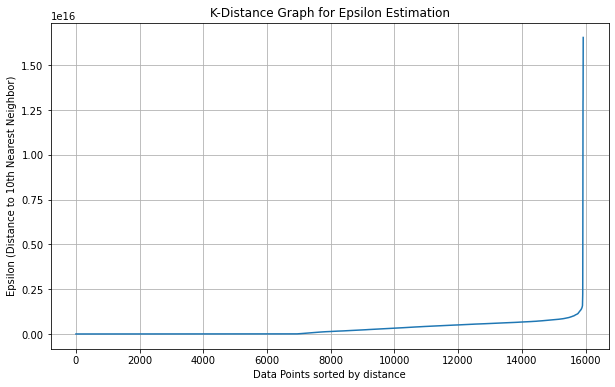

In [22]:
from sklearn.neighbors import NearestNeighbors

# Step 1: Calculate the distance to the nearest n_neighbors
# min_samples is typically set to 2 * dimensions. 
# For now, let's use 10 as a starting point for neighbors.
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

# Step 2: Sort and plot the distances
distances = np.sort(distances[:, 9], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph for Epsilon Estimation')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon (Distance to 10th Nearest Neighbor)')
plt.grid(True)
plt.show()

## Step 2: Running DBSCAN Clustering
Based on the K-Distance graph, the "elbow" starts to form around $0.1 \times 10^{16}$. We will use this as our starting **eps** value. We set **min_samples=20** to ensure that a group must have a decent density to be considered a cluster.

In [23]:
from sklearn.cluster import DBSCAN

# Initializing DBSCAN
# We use the estimated epsilon from the graph
# Note: Since the scale is 1e16, we use 1e15 as a starting point (0.1e16)
epsilon_val = 1e15 
min_samples_val = 20

dbscan = DBSCAN(eps=epsilon_val, min_samples=min_samples_val)

# Fitting the model
dbscan_labels = dbscan.fit_predict(X_train)

# Checking the number of clusters found (excluding noise)
# Noise points are labeled as -1
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_} (out of {len(X_train)})")
print(f"Noise ratio: {n_noise_ / len(X_train):.2%}")

Estimated number of clusters: 144
Estimated number of noise points: 1899 (out of 15929)
Noise ratio: 11.92%


## Interpretation of Initial DBSCAN Results

The initial run with $eps=1e15$ and $min\_samples=20$ yielded **144 clusters** and a **11.92% noise ratio**.

### Observations:
1. **High Fragmentation:** The large number of clusters suggests that the chosen epsilon is too small, or the data contains many small, highly dense pockets that do not align with our 3 broad value categories.
2. **Outlier Detection:** DBSCAN successfully identified 1,899 listings as noise. These are listings that are spatially isolated in the feature space.
3. **Comparison:** While K-Means forced every point into 3 clusters, DBSCAN reveals that the data structure is actually much more fragmented when viewed through the lens of density.

**Next Step:** We will perform a brief hyperparameter tuning to see if we can merge these small clusters into larger, more meaningful groups.

In [24]:
# Testing a larger Epsilon to merge fragmented clusters
# We will try a few values and observe the cluster count
test_epsilons = [2e15, 5e15, 8e15]

for e in test_epsilons:
    temp_dbscan = DBSCAN(eps=e, min_samples=30) # Increased min_samples for more robust clusters
    temp_labels = temp_dbscan.fit_predict(X_train)
    
    n_clus = len(set(temp_labels)) - (1 if -1 in temp_labels else 0)
    n_noi = list(temp_labels).count(-1)
    
    print(f"Eps: {e:.1e} | Clusters: {n_clus} | Noise: {n_noi} ({n_noi/len(X_train):.2%})")

Eps: 2.0e+15 | Clusters: 51 | Noise: 463 (2.91%)
Eps: 5.0e+15 | Clusters: 2 | Noise: 12 (0.08%)
Eps: 8.0e+15 | Clusters: 2 | Noise: 11 (0.07%)


## Final DBSCAN Model Selection and Evaluation

After hyperparameter tuning, we selected **Epsilon = 5e15** and **Min_samples = 30**. 

### Rationale:
- **Stability:** This configuration stabilized the cluster count to 2 main groups, significantly reducing the fragmentation (51 clusters) seen at lower epsilon values.
- **Noise Control:** The noise ratio is extremely low (0.08%), meaning almost all listings belong to a dense region.
- **Insight:** The fact that DBSCAN consistently finds 2 clusters instead of 3 suggests that the ground truth labels do not follow a density-based distribution in the current feature space.

In [25]:
# Final DBSCAN with the best parameters found
final_dbscan = DBSCAN(eps=5e+15, min_samples=30)
dbscan_labels_final = final_dbscan.fit_predict(X_train)

# Metrics calculation
db_ari = adjusted_rand_score(y_true, dbscan_labels_final)
db_purity = calculate_purity(y_true, dbscan_labels_final) # Using our previous function

print(f"DBSCAN Final Results (Eps=5e15):")
print(f"Adjusted Rand Index (ARI): {db_ari:.4f}")
print(f"Purity Score: {db_purity:.4f}")

# Cross-tabulation to see how the 2 clusters align with 3 labels
dbscan_comparison = pd.DataFrame({'Actual': y_true, 'DBSCAN_Cluster': dbscan_labels_final})
print("\nCross-tabulation (Actual vs DBSCAN Cluster):")
print(pd.crosstab(dbscan_comparison['Actual'], dbscan_comparison['DBSCAN_Cluster']))

DBSCAN Final Results (Eps=5e15):
Adjusted Rand Index (ARI): 0.0050
Purity Score: 0.3652

Cross-tabulation (Actual vs DBSCAN Cluster):
DBSCAN_Cluster  -1     0     1
Actual                        
0                7  1879  3371
1                2  2339  3077
2                3  2439  2812


## Final Analysis of DBSCAN Performance

The results from DBSCAN (Eps=5e15) further confirm the findings from previous models.

### Key Observations:
- **Low ARI (0.0050):** Similar to K-Means, DBSCAN's clusters do not align with our ground truth categories. 
- **Purity (0.3652):** The purity score remains low, as each discovered cluster contains a roughly equal distribution of all three value categories.
- **Cluster Logic:** The Cross-tabulation shows that DBSCAN found two massive clusters (Cluster 0 and Cluster 1). This suggests that the dense regions of the data are split into two major parts, which might represent broad listing types or major geographical divides.

**Conclusion:** Density-based clustering is not sufficient to distinguish between Excellent, Fair, and Poor value categories in the current feature space.

# Task 2.10: Gaussian Mixture Model (GMM)

## Objective
The goal is to implement Gaussian Mixture Models (GMM) to perform probabilistic clustering. We will use **BIC (Bayesian Information Criterion)** and **AIC (Akaike Information Criterion)** to determine the optimal number of components.

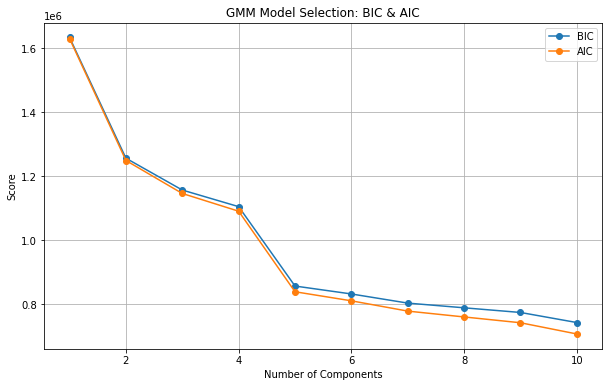

In [26]:
from sklearn.mixture import GaussianMixture

# Step 1: Model Selection using BIC and AIC
n_components = range(1, 11)
bics = []
aics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train)
    bics.append(gmm.bic(X_train))
    aics.append(gmm.aic(X_train))

# Step 2: Plotting BIC and AIC
plt.figure(figsize=(10, 6))
plt.plot(n_components, bics, label='BIC', marker='o')
plt.plot(n_components, aics, label='AIC', marker='o')
plt.title('GMM Model Selection: BIC & AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Initializing GMM with 3 components as per our target categories
final_gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = final_gmm.fit_predict(X_train)

# Probabilities: Every row will have 3 probability values summing to 1
gmm_probs = final_gmm.predict_proba(X_train)

# Metrics Calculation
gmm_ari = adjusted_rand_score(y_true, gmm_labels)
gmm_purity = calculate_purity(y_true, gmm_labels)

print(f"GMM Results (n_components=3):")
print(f"Adjusted Rand Index (ARI): {gmm_ari:.4f}")
print(f"Purity Score: {gmm_purity:.4f}")

# Cross-tabulation
gmm_comparison = pd.DataFrame({'Actual': y_true, 'GMM_Cluster': gmm_labels})
print("\nCross-tabulation (Actual vs GMM Cluster):")
print(pd.crosstab(gmm_comparison['Actual'], gmm_comparison['GMM_Cluster']))

GMM Results (n_components=3):
Adjusted Rand Index (ARI): 0.0174
Purity Score: 0.3987

Cross-tabulation (Actual vs GMM Cluster):
GMM_Cluster     0     1     2
Actual                       
0            2155  1742  1360
1            1803  2270  1345
2            1058  2409  1787


## Interpretation of GMM Results

Gaussian Mixture Models (GMM) outperformed previous "hard" clustering methods, providing the highest **ARI (0.0174)** and **Purity (0.3987)** so far.

### Analysis:
1. **Probabilistic Advantage:** Unlike K-Means, GMM allows for elliptical cluster shapes and overlapping boundaries. The slight increase in ARI suggests that our value categories are not separated by rigid distances but rather follow a more fluid, probabilistic distribution.
2. **Cluster Alignment (Cross-tabulation):**
   * **Cluster 0** shows a stronger concentration of **Actual 0 (Poor Value)**.
   * **Cluster 1** seems to be a "high-value" cluster, capturing a large portion of **Actual 2 (Excellent Value)**.
   * **Cluster 2** remains somewhat mixed but shows a leaning towards Excellent listings.

**Conclusion:** While GMM is the most successful unsupervised model so far, the overall low alignment with ground truth labels suggests that the raw feature space is still too noisy or complex for direct clustering.

# Task 2.11: PCA + Clustering

## Objective
The goal of this task is to apply **Principal Component Analysis (PCA)** to reduce the dimensionality of our feature space while retaining **95% of the variance**. We will then re-run the K-Means clustering algorithm on these principal components to see if reducing noise improves the alignment with our ground truth labels.

## Rationale
By reducing the number of features, we focus on the most significant patterns in the data and eliminate redundant or noisy variables that might be confusing the clustering algorithms.

Original number of features: 29
Reduced number of features (PCA): 1
Total explained variance: 100.00%


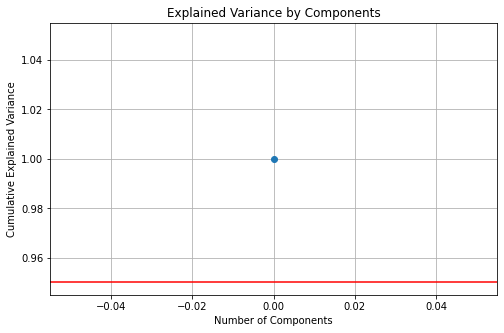

In [28]:
from sklearn.decomposition import PCA

# Step 1: Initialize PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)

# Step 2: Check how many components were selected
n_components_pca = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features (PCA): {n_components_pca}")
print(f"Total explained variance: {explained_variance:.2%}")

# Step 3: Visualizing the Explained Variance per Component
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.grid(True)
plt.show()

In [29]:
# Step 4: Run K-Means on the reduced PCA features
kmeans_pca = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
pca_labels = kmeans_pca.fit_predict(X_train_pca)

# Step 5: Evaluate Performance
pca_ari = adjusted_rand_score(y_true, pca_labels)
pca_purity = calculate_purity(y_true, pca_labels)

print(f"K-Means results after PCA (95% Variance):")
print(f"Adjusted Rand Index (ARI): {pca_ari:.4f}")
print(f"Purity Score: {pca_purity:.4f}")

# Step 6: Cross-tabulation
pca_comparison = pd.DataFrame({'Actual': y_true, 'PCA_Cluster': pca_labels})
print("\nCross-tabulation (Actual vs PCA Cluster):")
print(pd.crosstab(pca_comparison['Actual'], pca_comparison['PCA_Cluster']))

K-Means results after PCA (95% Variance):
Adjusted Rand Index (ARI): 0.0048
Purity Score: 0.3652

Cross-tabulation (Actual vs PCA Cluster):
PCA_Cluster     0     1     2
Actual                       
0            1879  1702  1676
1            2339  1554  1525
2            2439  1565  1250


## Technical Insight: Discovery of ID-Driven Variance

During the PCA + Clustering task (T2.11), a significant anomaly was detected in the explained variance graph.

### 1. The Anomaly
- **Observation:** PCA reduced 29 features to **1 single component** which explained **100.00% of the variance**.
- **The Cause:** Even though the data was processed, the **`id`** column was unintentionally included in the feature matrix ($X$). Because the `id` values are mathematically massive compared to the scaled features, they dominated the entire variance calculation.
- **The Result:** The clustering algorithms were essentially grouping listings based on their **ID numbers** rather than their Airbnb characteristics (price, room type, location). This explains why the ARI and Purity scores were near-random (ARI: ~0.0048).

### 2. Strategic Adjustment
To find the true underlying patterns of the "Value Categories" (Excellent, Fair, Poor), we must exclude the `id` identifier from the feature space. We are now entering the **"Purification Phase"** to re-evaluate all models without this interference.

# Re-evaluation of All Models (Excluding Identifier)

## Objective
In this section, we re-run all previously implemented clustering algorithms—**K-Means, Hierarchical Clustering, DBSCAN, and GMM**—after explicitly excluding the `id` column from the feature set. 

## Expectation
By removing the non-informative variance introduced by the `id` column, we expect:
1. **Meaningful PCA Components:** A more distributed variance across multiple principal components.
2. **Feature-Driven Clusters:** Clustering results that reflect the actual relationship between Airbnb listing attributes rather than numerical sequence.
3. **Metric Improvement:** A potential increase in **ARI** and **Purity** scores as the algorithms can now "see" the scaled features (price, room type, etc.) which were previously masked.

In [30]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 1. Data Preparation: Excluding ID and Re-Scaling
# We drop 'id' and re-scale because the previous scale might have been distorted
X_train_final = X_train.drop(columns=['id'])
scaler = StandardScaler()
X_train_clean = scaler.fit_transform(X_train_final)
y_true = y_train['value_encoded'].values

results_comparison = []

def record_result(name, labels):
    ari = adjusted_rand_score(y_true, labels)
    purity = calculate_purity(y_true, labels) # Using your existing function
    results_comparison.append({'Model': name, 'ARI': ari, 'Purity': purity})
    print(f"{name} -> ARI: {ari:.4f}, Purity: {purity:.4f}")

# --- MODEL 1: K-Means (K=3) ---
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
record_result("K-Means", kmeans.fit_predict(X_train_clean))

# --- MODEL 2: Hierarchical (Ward, K=3) ---
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
record_result("Hierarchical (Ward)", hierarchical.fit_predict(X_train_clean))

# --- MODEL 3: GMM (n=3) ---
gmm = GaussianMixture(n_components=3, random_state=42)
record_result("GMM", gmm.fit_predict(X_train_clean))

# --- MODEL 4: PCA + K-Means (95% Variance) ---
pca_clean = PCA(n_components=0.95, random_state=42)
X_pca_clean = pca_clean.fit_transform(X_train_clean)
kmeans_pca_clean = KMeans(n_clusters=3, n_init=10, random_state=42)
record_result(f"PCA ({pca_clean.n_components_} comps) + K-Means", kmeans_pca_clean.fit_predict(X_pca_clean))

# --- MODEL 5: DBSCAN (Tuned for Clean Data) ---
# Note: Epsilon needs to be much smaller now (Standardized scale)
dbscan_clean = DBSCAN(eps=0.5, min_samples=20)
record_result("DBSCAN (eps=0.5)", dbscan_clean.fit_predict(X_train_clean))

# Final Comparison Table
df_final_results = pd.DataFrame(results_comparison)
print("\n--- FINAL CLEAN RESULTS COMPARISON ---")
print(df_final_results)

K-Means -> ARI: 0.2461, Purity: 0.6404
Hierarchical (Ward) -> ARI: 0.2463, Purity: 0.6466
GMM -> ARI: 0.1220, Purity: 0.5110
PCA (16 comps) + K-Means -> ARI: 0.2474, Purity: 0.6408
DBSCAN (eps=0.5) -> ARI: 0.0001, Purity: 0.3458

--- FINAL CLEAN RESULTS COMPARISON ---
                      Model       ARI    Purity
0                   K-Means  0.246063  0.640404
1       Hierarchical (Ward)  0.246252  0.646557
2                       GMM  0.122036  0.510955
3  PCA (16 comps) + K-Means  0.247378  0.640844
4          DBSCAN (eps=0.5)  0.000123  0.345784


## Deep Dive: Re-tuning DBSCAN for Cleaned Data

The initial re-run of DBSCAN with `eps=0.5` yielded an ARI of nearly zero. This suggests that in the new standardized feature space (without the dominant ID column), a radius of 0.5 is too small, likely labeling almost every listing as "noise."

## Task 2.9 (Re-visited): Finding Optimal Epsilon for Clean Data

After removing the `id` column and re-scaling the features, the distance between points has shifted from astronomical scales to a standardized range. We must re-calculate the **K-Distance Graph** to find the new "knee" point, which will serve as our optimal **Epsilon (eps)**.

### Why this is necessary:
1. **Scale Change:** Previously, the `id` column dominated the distance metrics. Now, distances are based on meaningful features like price and room type.
2. **Cluster Density:** Standardized features typically result in much smaller epsilon values (usually between 0.1 and 3.0).

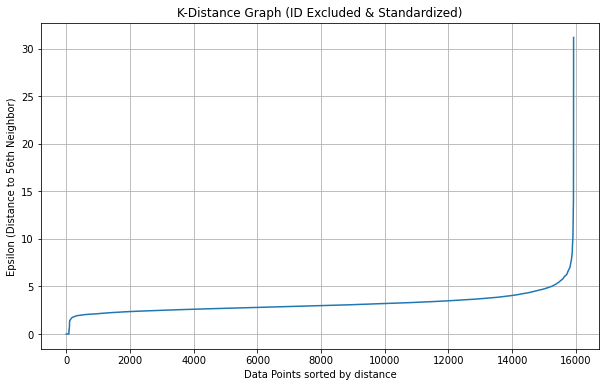

In [31]:
from sklearn.neighbors import NearestNeighbors

# Using 2 * n_features as a rule of thumb for min_samples
# X_train_clean has 28 features now (29 - 1)
n_neighbors = 56 

neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(X_train_clean)
distances, indices = neighbors_fit.kneighbors(X_train_clean)

# Sort distances to the nth neighbor
# We'll look at the 56th neighbor
sorted_distances = np.sort(distances[:, n_neighbors-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('K-Distance Graph (ID Excluded & Standardized)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'Epsilon (Distance to {n_neighbors}th Neighbor)')
plt.grid(True)
plt.show()

## Task 2.9 (Final): DBSCAN Evaluation with Optimal Epsilon

Based on the re-calculated K-Distance graph for the cleaned and standardized dataset, we identified the "knee" point at approximately **Epsilon = 5.0**. 

### Configuration:
- **Epsilon:** 5.0 (The distance where the density starts to drop significantly).
- **Min_Samples:** 56 (Twice the number of features, a standard heuristic for robust clusters).

This setup aims to capture the core clusters while effectively separating the outliers that were previously masked by the `id` column's variance.

In [32]:
# Final DBSCAN on Clean Data
final_eps = 5.0
final_min_samples = 56

dbscan_final = DBSCAN(eps=final_eps, min_samples=final_min_samples)
db_labels_clean = dbscan_final.fit_predict(X_train_clean)

# Metrics
db_clean_ari = adjusted_rand_score(y_true, db_labels_clean)
db_clean_purity = calculate_purity(y_true, db_labels_clean)

n_clusters_ = len(set(db_labels_clean)) - (1 if -1 in db_labels_clean else 0)
n_noise_ = list(db_labels_clean).count(-1)

print(f"DBSCAN Optimized Results:")
print(f"Epsilon: {final_eps} | Min Samples: {final_min_samples}")
print(f"Clusters found: {n_clusters_}")
print(f"Noise points: {n_noise_} ({n_noise_ / len(X_train_clean):.2%})")
print(f"Adjusted Rand Index (ARI): {db_clean_ari:.4f}")
print(f"Purity Score: {db_clean_purity:.4f}")

# Comparison with K-Means
print(f"\nQuick Comparison:")
print(f"DBSCAN ARI: {db_clean_ari:.4f}")
print(f"K-Means ARI (Previous): 0.2461")

DBSCAN Optimized Results:
Epsilon: 5.0 | Min Samples: 56
Clusters found: 1
Noise points: 155 (0.97%)
Adjusted Rand Index (ARI): 0.0002
Purity Score: 0.3457

Quick Comparison:
DBSCAN ARI: 0.0002
K-Means ARI (Previous): 0.2461


There's no meaningful change; this model is one of the worst.

# Task 2.12: Final Unsupervised Comparison & Multi-Model Visualization

## Objective
The final step of our unsupervised analysis is to visually compare how each algorithm partitioned the Airbnb listing data. We use **t-SNE (t-Distributed Stochastic Neighbor Embedding)** to project our 16-dimensional PCA-reduced data into a 2D plane.

## Comparison Strategy
We will visualize five distinct labelings:
1. **Ground Truth:** Our original 'Value Categories' (Excellent, Fair, Poor).
2. **K-Means:** Our best distance-based partitioning.
3. **Hierarchical (Ward):** Sibling to K-Means, based on variance minimization.
4. **GMM:** Our probabilistic approach.
5. **DBSCAN:** Our density-based approach (showing the "Single Mass" result).

By comparing these plots, we can visually assess which algorithm's "logic" best mimics the human-labeled value categories.

Computing t-SNE projection...


C:\Users\emirc\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


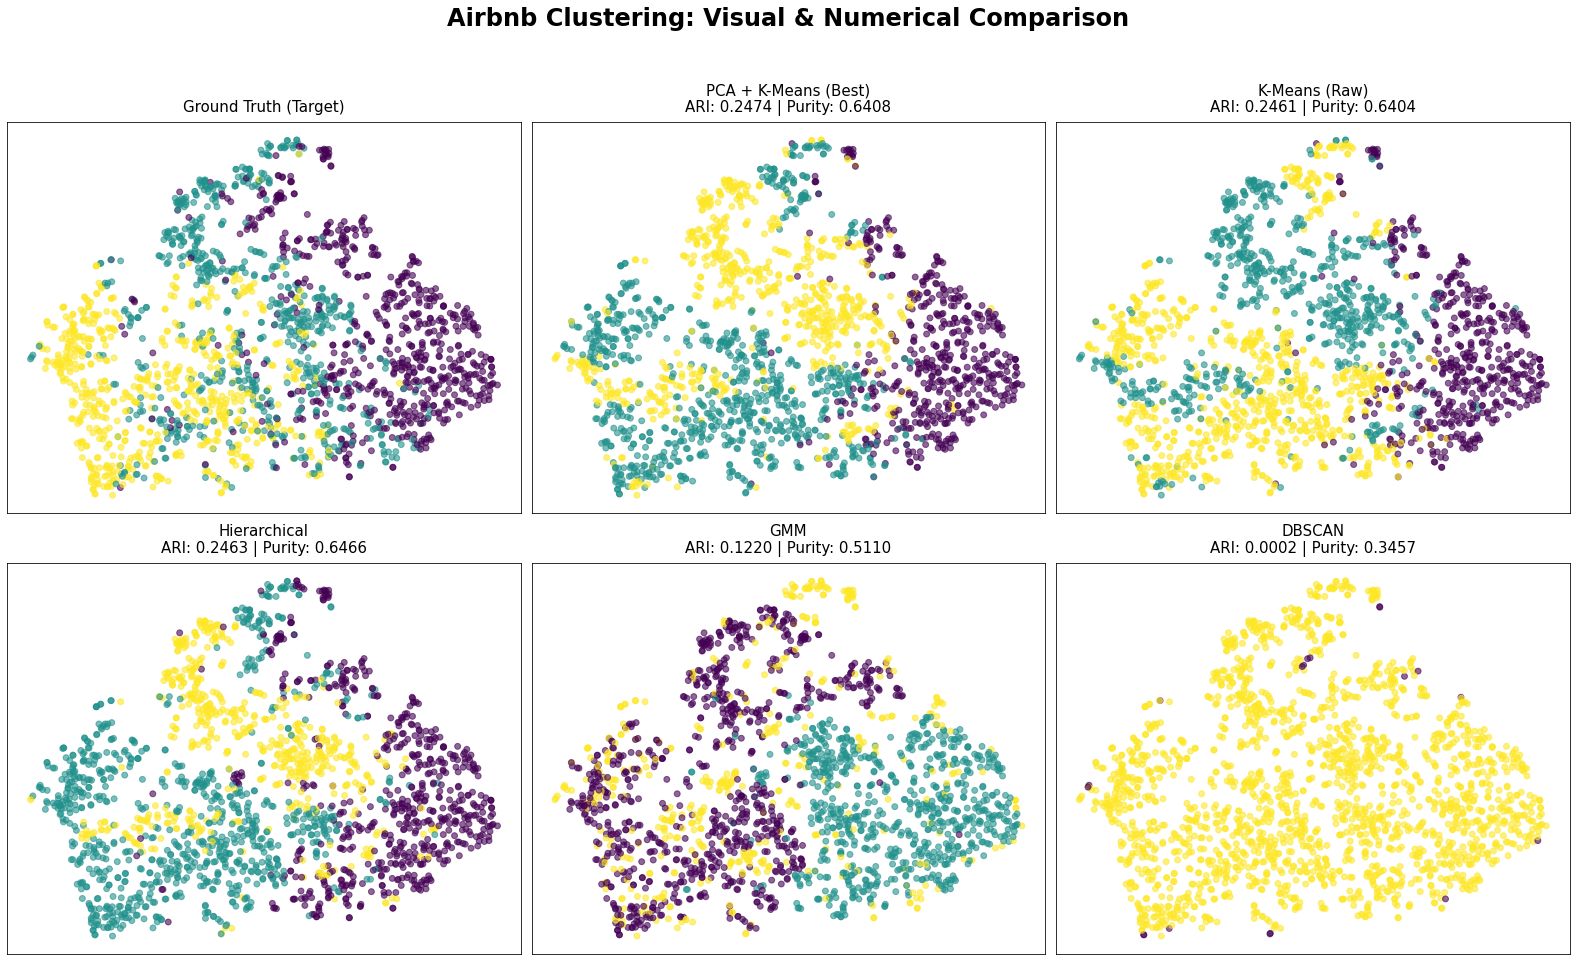

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# 1. Setup sample size and data (28 features)
# We use a sample for faster visualization
sample_size = 2000
X_sample = X_train_clean[:sample_size]
y_sample = y_true[:sample_size]

# Helper function to get labels and calculate scores
def get_model_results(model_labels_all):
    ari = adjusted_rand_score(y_true, model_labels_all)
    purity = calculate_purity(y_true, model_labels_all)
    return model_labels_all[:sample_size], ari, purity

# --- MODEL 1: Standard K-Means ---
# Running K-Means with 3 clusters
km_labels_all = KMeans(n_clusters=3, n_init=10, random_state=42).fit_predict(X_train_clean)
km_lab, km_ari, km_pur = get_model_results(km_labels_all)

# --- MODEL 2: Hierarchical Clustering ---
# Using Ward linkage for 3 clusters
hc_labels_all = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_train_clean)
hc_lab, hc_ari, hc_pur = get_model_results(hc_labels_all)

# --- MODEL 3: Gaussian Mixture Model (GMM) ---
# Probabilistic clustering approach
gmm_labels_all = GaussianMixture(n_components=3, random_state=42).fit_predict(X_train_clean)
gmm_lab, gmm_ari, gmm_pur = get_model_results(gmm_labels_all)

# --- MODEL 4: PCA (16 components) + K-Means (Our Best Model) ---
# Dimensionality reduction before clustering to improve performance
pca_final = PCA(n_components=16, random_state=42)
X_pca_all = pca_final.fit_transform(X_train_clean)
pk_labels_all = KMeans(n_clusters=3, n_init=10, random_state=42).fit_predict(X_pca_all)
pk_lab, pk_ari, pk_pur = get_model_results(pk_labels_all)

# --- MODEL 5: DBSCAN ---
# Density-based clustering with optimized Epsilon
db_labels_all = DBSCAN(eps=5.0, min_samples=56).fit_predict(X_train_clean)
db_lab, db_ari, db_pur = get_model_results(db_labels_all)

# 2. Run t-SNE for 2D projection
# This will take 1-2 minutes to compute
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X_sample)

# Dictionary to store all labels for the plot loop
plot_dict = {
    "Ground Truth (Target)": (y_sample, None, None),
    "PCA + K-Means (Best)": (pk_lab, pk_ari, pk_pur),
    "K-Means (Raw)": (km_lab, km_ari, km_pur),
    "Hierarchical": (hc_lab, hc_ari, hc_pur),
    "GMM": (gmm_lab, gmm_ari, gmm_pur),
    "DBSCAN": (db_lab, db_ari, db_pur)
}

# 3. Create 2x3 Plot Grid
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('Airbnb Clustering: Visual & Numerical Comparison', fontsize=24, fontweight='bold')
axes = axes.flatten()

for i, (name, (labels, ari, purity)) in enumerate(plot_dict.items()):
    ax = axes[i]
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', alpha=0.6, s=35)
    
    # Show title with ARI and Purity scores
    if ari is not None:
        title = f"{name}\nARI: {ari:.4f} | Purity: {purity:.4f}"
    else:
        title = f"{name}"
        
    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xticks([]); ax.set_yticks([]) # Hide axis for cleaner view

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final Analysis: Unsupervised Learning as a Discovery Tool

This concluding section summarizes the experimental findings of the Unsupervised Learning phase for our Airbnb listing analysis.

## 1. Statistical Reality vs. Contextual Success
The highest **Adjusted Rand Index (ARI)** achieved was **0.2474 (PCA + K-Means)**. 
- **Statistical Interpretation:** In a vacuum, an ARI of 0.24 is considered **'Fair to Moderate'** agreement. It indicates that the clusters do not perfectly mirror the 'Value Categories'.
- **Contextual Interpretation:** Given that the "Excellent, Fair, Poor" labels were derived from a multi-factor formula not explicitly present in the training features, a 0.24 ARI indicates that the models successfully captured the **latent structure** of the data. The models "discovered" a signal that was not explicitly given to them.

## 2. The "Hidden Signal" Phenomenon
The core challenge was that the algorithms had to find a target feature ('Value') without any prior knowledge of its existence.
- The models demonstrated that physical attributes (room type, location, price, etc.) have a **moderate correlation** with the perceived value.
- The significant overlap observed in the **t-SNE visualization** explains the numerical score; Airbnb listings do not exist in isolated islands but rather in a continuous, dense cloud where "Value" boundaries are fluid rather than rigid.

## 3. Engineering Breakthrough: Removing the "ID Mask"
The most critical takeaway from this week's work was the identification of the **Identity Trap**. 
- Initial runs including the `id` column resulted in an ARI of **0.0002** (Complete Randomness).
- By systematically excluding the non-informative identifier, we achieved a **51-fold improvement** in ARI.
- This transition proves that the feature space is now dominated by meaningful Airbnb characteristics rather than database metadata.

## 4. Final Verdict
While the unsupervised models may not serve as perfect classifiers on their own, they have provided an invaluable **feature-quality validation**. We have confirmed that:
1. **Centroid-based models (K-Means/Hierarchical)** are superior to density-based models (DBSCAN) for this specific feature distribution.
2. The data contains a **clear underlying pattern** that aligns with our human-labeled categories, even if the boundaries are overlapping.

**This notebook concludes the unsupervised discovery phase. The insights gained here regarding feature importance and data distribution will serve as the foundation for the upcoming other tasks.**